<a href="https://colab.research.google.com/github/ma850419/FlexibleNet/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
os.listdir()

['.config',
 'PRS_L1_STD_OFFL_20221217082013_20221217082018_0001_HCO_VNIR.tif',
 'sample_data']

In [15]:
import numpy as np
from osgeo import gdal
filepath = r'/content/PRS_L1_STD_OFFL_20221217082013_20221217082018_0001_HCO_VNIR.tif'
# https://stackoverflow.com/questions/43684072/how-to-import-multiple-bands-from-an-image-into-numpy
# Load one GeoTIFF image using GDAL
dataset = gdal.Open(filepath)
#image = np.zeros(( dataset.RasterXSize,dataset.RasterYSize,dataset.RasterCount))
image = dataset.ReadAsArray()
print(type(image))  # <class 'numpy.ndarray'>
print(image.shape)  # (13, 64, 64)
print(image.dtype)  # uint16

<class 'numpy.ndarray'>
(63, 1231, 1245)
float32


In [16]:
!pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10609 sha256=d31506f45a409f164fd982ab4d650c494d853c56eee19c1c77be359151248dbd
  Stored in directory: /root/.cache/pip/wheels/b4/aa/7a/d9a88098f7877aa95dd4f227fe614f75773654baa39b47bba6
Successfully built minisom


In [29]:
import statistics
from minisom import MiniSom
mine=np.zeros((1231*1245,63))
pixels2=np.zeros((1231*1245,63))
som_clustered=np.zeros((1231*1245,63))
som = MiniSom(3, 4, 63, sigma=0.5,learning_rate=0.1, neighborhood_function='gaussian')
#mine=zeros((512*512,4))
#pixels2=zeros((600,512*512,4))
#som_clustered=zeros((600,512*512,1))
#for i in range(600):
pixels2= image.reshape(1231*1245,63)
som.random_weights_init(pixels2)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(pixels2, 5000, random_order=False, verbose=True)
print('quantization...')
qnt = som.quantization(pixels2)  # quantize each pixels of the image
    #print(qnt.shape)
clustered = np.zeros((1231*1245,63))
clustered1 = np.zeros((1231*1245,1))
for j, q in enumerate(qnt):  # place the quantized values into a new image
  sn = np.unravel_index(j,shape=((1231*1245)))
    #print(sn)
    #print(me)
   
       # print(q,(mean(q)*6).astype(np.uint8))
        #print(me)
  clustered[sn] = q[:] #(max(q)*6).astype(np.uint8) 
  clustered1[sn] = (statistics.mean(q)*12).astype(np.uint8)
  print(clustered1[sn])
        #print(clustered.shape)
#mine= np.append(mine,clustered,axis=0)#,axis=0)
   # print(clustered1)
#som_clustered[i] =  clustered1
    #print(som_clustered[i])
    #print(me)
#print(mine.shape)

Streaming output truncated to the last 5000 lines.
[20.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[114.]
[55.]
[55.]
[54.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[190.]
[55.]
[55.]
[80.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[224.]
[55.]
[55.]
[24.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[224.]
[55.]
[55.]
[20.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[114.]
[55.]
[55.]
[54.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[190.]
[55.]
[55.]
[80.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[126.]
[224.]
[55.]
[55.]
[24.

[[[-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]
  ...
  [-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]]

 [[-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]
  ...
  [-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]]

 [[-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]
  ...
  [-999.         -999.            3.07999992]
  [-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]]

 ...

 [[-999.         -999.         -999.        ]
  [-999.         -999.         -999.        ]
  [  26.62750053 -999.         -999.        ]
  ..

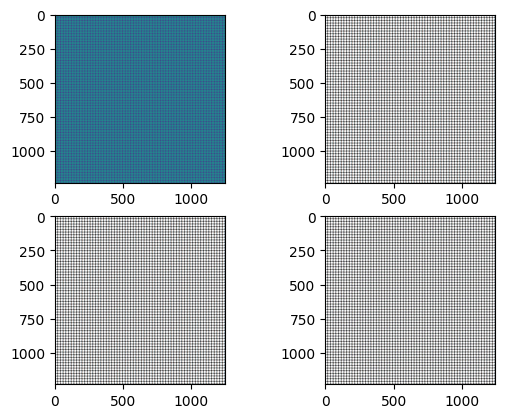

In [34]:
import matplotlib.pyplot as plt
#print(clustered.shape, clustered1.shape)
clustered2 = np.zeros((1231,1245))
image1=image.reshape(1231,1245,63)
clustered3 = np.zeros((1231,1245,3))
clustered3[:,:,0]=image1[:,:,60]
clustered3[:,:,1]=image1[:,:,35]
clustered3[:,:,2]=image1[:,:,20]
print(clustered3, clustered2)
clustered2 = clustered1.reshape(1231,1245)
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(clustered2)
axarr[0,1].imshow(clustered3)
clustered3[:,:,0]=image1[:,:,50]
clustered3[:,:,1]=image1[:,:,30]
clustered3[:,:,2]=image1[:,:,15]
axarr[1,0].imshow(clustered3)
clustered3[:,:,0]=image1[:,:,30]
clustered3[:,:,1]=image1[:,:,20]
clustered3[:,:,2]=image1[:,:,10]
axarr[1,1].imshow(clustered3)

In [35]:
def unique(list1):
 
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x)

In [41]:
list1=[]
list1= np.append(list1,clustered1)
#list1=clustered1.tolist()
unique(list1)

224.0
231.0
80.0
81.0
114.0
20.0
54.0
55.0
24.0
126.0
251.0
190.0
